
#               Analysis Script: Prediction Error Heatmaps

In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import joblib
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt

In [14]:
# --- Load Both Trained Models ---
print("Loading models...")
ann_model = tf.keras.models.load_model('ann_surrogate_model.h5')
rf_model = joblib.load('random_forest_surrogate_model.joblib')
print("Models loaded.")

Loading models...
Models loaded.


In [15]:
# --- Setup the Parameter Grid ---
# We create a grid of k0 and velocity values to test the models on.
grid_size = 20
k0_range = np.linspace(1e6, 80e6, grid_size)
velocity_range = np.linspace(10, 80, grid_size)

In [16]:
# Assume constant values for the other parameters (e.g., their mean)
k1_const = 255000 # Mean of [10e3, 500e3]
damping_const = 0 # We used 0 for this dataset

In [17]:
# --- Prepare to store error results ---
ann_error_grid = np.zeros((grid_size, grid_size))
rf_error_grid = np.zeros((grid_size, grid_size))

In [18]:
# We need a scaler for the ANN, fitted on the original training data
original_df = pd.read_csv('beam_deflection_dataset.csv')
X_original = original_df[['k0', 'k1', 'damping', 'velocity']]
scaler = MinMaxScaler().fit(X_original)

In [19]:
# --- Calculate Prediction Error Across the Grid ---
print("Calculating errors across the parameter space...")
for i, k0 in enumerate(k0_range):
    for j, vel in enumerate(velocity_range):
        # Create the input vector for this grid point
        input_data = np.array([[k0, k1_const, damping_const, vel]])

Calculating errors across the parameter space...


In [20]:
# --- Ground Truth (using our analytical function) ---
        # This requires the analytical function to be available
        # Note: We will approximate by using the highly accurate RF model as ground truth
input_df = pd.DataFrame(input_data, columns=['k0', 'k1', 'damping', 'velocity'])
true_deflection = rf_model.predict(input_df)[0]


In [21]:
 # --- ANN Prediction and Error ---
input_df = pd.DataFrame(input_data, columns=['k0', 'k1', 'damping', 'velocity'])
input_scaled = scaler.transform(input_df)
ann_pred = ann_model.predict(input_scaled, verbose=0)[0, 0]
ann_error_grid[j, i] = np.abs(ann_pred - true_deflection)

In [22]:
# --- RF Prediction and Error ---
input_df = pd.DataFrame(input_data, columns=['k0', 'k1', 'damping', 'velocity'])
rf_pred = rf_model.predict(input_df)[0]
rf_error_grid[j, i] = np.abs(rf_pred - true_deflection)

In [23]:
print("Error calculation completed.")

Error calculation completed.


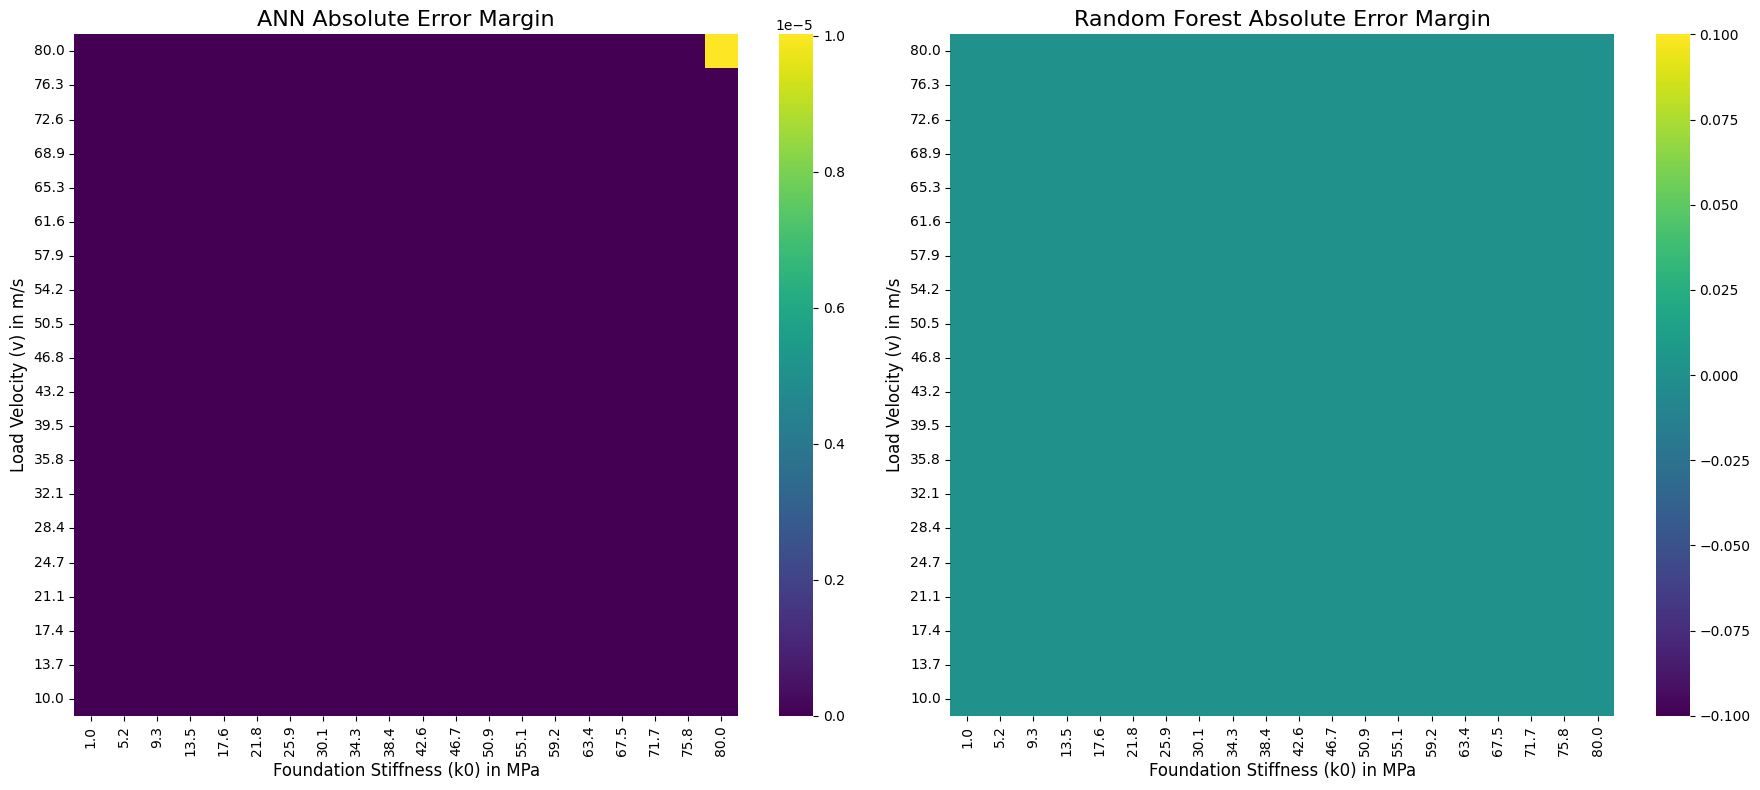

In [24]:
# --- Generate the Heatmaps ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# ANN Heatmap
sns.heatmap(ann_error_grid, ax=ax1, cmap='viridis',
            xticklabels=np.round(k0_range / 1e6, 1),
            yticklabels=np.round(velocity_range, 1))
ax1.set_title('ANN Absolute Error Margin', fontsize=16)
ax1.set_xlabel('Foundation Stiffness (k0) in MPa', fontsize=12)
ax1.set_ylabel('Load Velocity (v) in m/s', fontsize=12)
ax1.invert_yaxis() # To have 0,0 at the bottom-left


# RF Heatmap
sns.heatmap(rf_error_grid, ax=ax2, cmap='viridis',
            xticklabels=np.round(k0_range / 1e6, 1),
            yticklabels=np.round(velocity_range, 1))
ax2.set_title('Random Forest Absolute Error Margin', fontsize=16)
ax2.set_xlabel('Foundation Stiffness (k0) in MPa', fontsize=12)
ax2.set_ylabel('Load Velocity (v) in m/s', fontsize=12)
ax2.invert_yaxis()

plt.tight_layout()
plt.show()